![corrective-rag](https://i.imgur.com/IzvmbWN.png)

In [30]:
from dotenv import load_dotenv

load_dotenv()

True

In [31]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embeddings,
    collection_name='income_tax_coll',
    persist_directory='./income_tax_coll' 
)

retriever = vector_store.as_retriever(search_kwargs={'k': 5})

In [ ]:
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    a : str

graph_builder = StateGraph(AgentState)

In [33]:
def retrieve(state: AgentState) -> AgentState:

    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [34]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [35]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
    
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | llm | StrOutputParser()
    response = rag_chain.invoke({'question': query, 'context': context})
    return {'answer': response}

/opt/anaconda3/envs/inflearn_langgraph/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [36]:
from langchain import hub
from langsmith import Client
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    
    query = state['query']  
    context = state['context']   
    print(f'context == {context}')
    doc_relevance_chain = doc_relevance_prompt | llm    
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})  
    print(f'doc relevance responce: {response}')
    if response['Score'] == 1:  
        return 'relevant'
    
    return 'irrelevant'

/opt/anaconda3/envs/inflearn_langgraph/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


위에서 Retrieve / Grade / Generate 까지는 OK → Re-write, Wep Search 작업 ㄱㄱ

In [37]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
 

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요.
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState: 
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    
    response = rewrite_chain.invoke({'query': query})
    return{'query': response}    

In [38]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)

def web_search(state: AgentState):
    query = state['query']
    results = tavily_search_tool.invoke(query)
    return {'context': results}

노드 및 엣지 추가
- check_doc_relevance는 노드로 추가 nope.

In [39]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('web_search', web_search)

In [40]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelevant': 'rewrite'
    }                                    
)
graph_builder.add_edge('rewrite', 'web_search')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)



In [41]:
graph = graph_builder.compile()

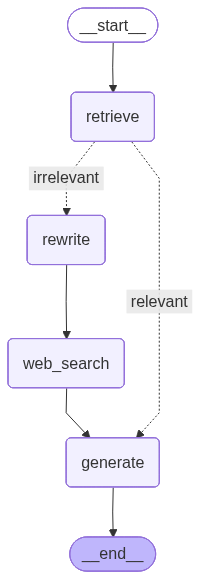

In [42]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

CRAG 파이프라인
- retrieve (검색)
- 관련 있으면 그대로 답변 생성, 그렇지 않으면 웹 검색에 용이하게 쿼리 정제
- 웹 검색을 바탕으로 답변 생성

In [44]:
initial_state = {'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

context == [Document(metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n종합소득\n┌───────────────┐\n│ 과세표준의 6개 구간 │\n├───────────────┤\n│ 1,400

{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n종합소득\n┌───────────────┐\n│ 과세

In [45]:
initial_state = {'query': '영통역 맛집을 추천해주세요'}
graph.invoke(initial_state)

context == [Document(metadata={'source': './documents/income_tax.txt'}, page_content='담당세무서로서 담당공무원에게 지명이음으로는 보호를 위하는 바에 따라 담의 다음을 말하기는 것에 대한 해상금의 숙소는 본 해당하는 숙소는 달의 다음과 함께 말할 것이다. <개정 2020. 12. 29, 2021. 3. 16.>\n법제처 151\n국가법전정보센터'), Document(metadata={'source': './documents/income_tax.txt'}, page_content='특소, 계좌, 계좌기 등 성명·로렌, 타박, 감정 등의 관련 용의의 제공을 발행하는 국내원천소득 또는 제119조제16조에 따른 인적욕을 제공함에 따른 국내원천소득(조세적외의 사업소득으로 규부되는 경우를 포함한다) 비거주자에게 지급하는 자는 비거주자와 국내사업장을 가지는 경우에도 제119조에 따른 원천징수를 하여야 한다. 다만, 비거주자제 제168조에 따라 사업자등록을 한 경우는 제외한다.<개정 2010. 12. 27., 2013. 1. 1., 2014. 1. 1.>'), Document(metadata={'source': './documents/income_tax.txt'}, page_content='국내원천 부동산소득: 국내에 있는 부동산 또는 부동산실양 권리와 국내에서 취득한 광업, 조광업, 지하수의 개발· 이용을 포함하여, 토지와 채권에 관한 권리의 양도·임대, 그 밖의 운영으로 인하여 발생하는 소득. 단, 제9호에 따른 국내원천 부동산소득은 제외한다.  \n\n\n국내업체 선박의 낙선소득: 거주자·내국법인 또는 합법법인 법정서비, 제54조제6항에 규정하는 외국법인의 국내사업이나 제120조에서 규정하는 비거주자의 국내사업장에 선박, 항공기, 자동차·건설기계 또는 산업용·상업용 과학기기의 기계·설비·장치, 이 밖에 대통령령으로 정하는 용구를 일반적으로 발생하는 소득  \n\n\n국내원천 사업소득: 비거주자가 경영하는

{'query': '영통역 근처 인기 맛집 추천',
 'context': [{'url': 'https://hotel-iu.tistory.com/3556',
   'content': "# 초코초코 해피라이프\n\n추천 TOP 10\n\n## 영통역 맛집 베스트 추천 top 10\n\n#### 영통역 맛집 베스트 추천 top 10\n\n영통역 맛집 베스트 추천 top 10곳을 소개합니다.\n\n|  |\n\n| 1: 징기스 영통점 |\n|  |\n| 상호명: 징기스 영통점  주소: 경기도 수원시 영통구 영통동 1002-1 1층 징기스 영통점  전화번호: 미입력  관련 키워드: 키워드 미입력  관련 태그: ['데이트하기 좋은', '모임하기 좋은', '단체회식']  영업시간: 매일 17:00~00:00 라스트 오더 11시 |\n| 소개글: 안녕하세요~ 영통 양갈비 전문점 징기스 영통점 입니다. 징기스 영통점의 양고기는 생후6개월 미만의 어린양(램)과 1년 이상의 양(머튼)으로 구분되며 ,징기스는 생후6개월 미만의 어린양만 사용하여 양고기 특유의 냄새가 없고 육질이 연하며 기타의 육류보다 영양분이 뛰어나 '육류의 왕' 으로 불리우며 보양에 좋은 식재료 입니다. 양고기의 효능 本草綱目(본초강목) 東醫寶鑑(동의보감)에 살펴보면 정력과 기운을 돋우고 비장과 위를 튼튼히 해주며, 오장을 보호하며 어지럼증 (혈압)을 다스리는 효능이 있습니다. 또한 당뇨,술중독,몸의 독성해소,장내해독 살균,이뇨,피부미용,피로회복,노약자의 양기부족,골다공증등에 효능이 있습니다. 영통 양고기 전문점 징기스 영통점은 항상 고객분들에게 최고의 맛과 서비스를 위해 최선을 다하는 징기스 영통점이 되겠습니다. |\n|  징기스 영통점 바로가기▲ |\n\n|  | [...] | 7: 승도리네 곱도리탕 영통점 |\n|  |\n| 상호명: 승도리네 곱도리탕 영통점  주소: 경기도 수원시 영통구 영통동 1011-5 영통테라스가든 제1층 제115호  전화번호: 미입력  관련 키워드: 키워드 미입력  관련 태그: ['